#  Bike Sharing Demand Forecasting Using Time Series and Machine Learning Models

---

##  **Introduction**

- **Bike-sharing systems** have become an essential part of **sustainable urban transportation**, offering an eco-friendly solution for short-distance commuting.  
- To ensure efficient operations, it is important to **forecast user demand** accurately so that bikes are available when and where needed.  
- **Time Series Forecasting (TSF)** techniques help capture **trends, seasonality, and cyclic variations** in bike usage data over time.  
- This project compares multiple forecasting models — **SARIMAX**, **Holt-Winters**, **Prophet**, **LSTM**, and **Random Forest** — to predict **daily bike demand**.  
- The models are evaluated using performance metrics such as **RMSE** and **MAPE** to determine forecasting accuracy.  
- External factors like **weather conditions**, **holidays**, and **working days** are included to improve prediction reliability.  
- The objective is to identify the **most accurate and practical model** for short-term demand forecasting, enabling **better operational planning** and **resource management**.  

---



 *Project by:* **Sarthak Mokal** & **Shalaka Gangurde**  
 *Under the guidance of:* **Prof. Dhanashree Tamhane**  
 *Department of Electronics & Computer Science, Vidyalankar Institute of Technology (2025–26)*


## 📂 Step 1: Mount Google Drive and Load Dataset

In this step, we connect our Google Drive to the Colab environment to access the dataset stored in it.  
We then load the **Daily Bike Sharing** dataset using **Pandas** for further analysis.

In [ ]:
# Mount Drive to access files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

path = "/content/drive/MyDrive/Daily Bike Sharing training.csv"
df = pd.read_csv(path)
df.head()


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,1/1/2011,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,1/2/2011,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,1/3/2011,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,1/4/2011,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,1/5/2011,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


##  Step 2: Importing Libraries

We import all required libraries for **data handling**, **visualization**, **time series analysis**, and **model building**.

### 📦 Libraries Used:
- **pandas, numpy** → Data manipulation and numerical operations  
- **matplotlib.pyplot** → Plotting and visualizing trends  
- **statsmodels** → For SARIMAX, Holt-Winters, and time series decomposition  
- **sklearn** → Random Forest, scaling, and evaluation metrics (RMSE, MAE)  
- **tensorflow.keras** → Building LSTM models (Sequential, LSTM, Dense, Dropout)  
- **math** → Basic mathematical operations  




In [ ]:

# Libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from sklearn.model_selection import ParameterGrid

In [ ]:
# Additional imports for new models & evaluation
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import math


##  Step 3: Dataset Information

In [ ]:
# Display information about the DataFrame, including data types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     701 non-null    int64  
 1   dteday      701 non-null    object 
 2   season      701 non-null    int64  
 3   yr          701 non-null    int64  
 4   mnth        701 non-null    int64  
 5   holiday     701 non-null    int64  
 6   weekday     701 non-null    int64  
 7   workingday  701 non-null    int64  
 8   weathersit  701 non-null    int64  
 9   temp        701 non-null    float64
 10  atemp       701 non-null    float64
 11  hum         701 non-null    float64
 12  windspeed   701 non-null    float64
 13  casual      701 non-null    int64  
 14  registered  701 non-null    int64  
 15  cnt         701 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 87.8+ KB


##  Step 4: Data Preprocessing and Cleaning

### 🔹 Renaming Columns
- Renamed `dteday` → **ds** (date column) and `cnt` → **y** (target variable)  
- This naming convention aligns with time series libraries like **Prophet**.

In [ ]:
# Change the time Series variable name
# target variable as 'y'
# date as 'ds'
df = df.rename(columns = {'cnt': 'y',
                          'dteday': 'ds'})
df.head()

,instant,ds,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,y
0,1,1/1/2011,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,1/2/2011,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,1/3/2011,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,1/4/2011,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,1/5/2011,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


### 🔹 Converting Date Format
- Converted `ds` column from string to **datetime (YYYY-MM-DD)** using `pd.to_datetime()`.  
- Ensures correct time-based indexing and sorting for time series models.

In [ ]:
# Change 'ds' into format YYYY-MM-DD
df['ds'] = pd.to_datetime(df['ds'], format = "%m/%d/%Y")
df.head()

,instant,ds,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,y
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [ ]:
# Prepare the weather situation variable (robust + readable)
if 'weathersit' not in df.columns:
    raise KeyError("Column 'weathersit' not found in df")

# create dummies with a prefix so column names are meaningful
weather_sit = pd.get_dummies(df['weathersit'], prefix='weathersit', drop_first=True)

# ensure dummy columns are integer dtype (optional but tidy)
weather_sit = weather_sit.astype(int)

# concatenate into df
df = pd.concat([df.reset_index(drop=True), weather_sit.reset_index(drop=True)], axis=1)

# quick check - show first 5 rows (use head() not head(0))
df.head()


,instant,ds,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,y,weathersit_2,weathersit_3
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985,1,0
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801,1,0
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,0,0
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,0,0
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,0,0


### 🔹 Dropping Irrelevant Columns
- Removed unused or redundant columns like `instant`, `season`, `yr`, `mnth`, `weekday`, `casual`, and `registered`.  
- Keeps only essential features required for modeling (date, weather, temperature, humidity, windspeed, etc.).


In [ ]:
# Drop variables that are not needed (safe version)
cols_to_drop = ['instant', 'season', 'yr', 'mnth', 'weekday', 'casual', 'registered']
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore')

print("Remaining columns:")
print(df.columns.tolist())
df.head()


Remaining columns:
['ds', 'holiday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'y', 'weathersit_2', 'weathersit_3']


,ds,holiday,workingday,weathersit,temp,atemp,hum,windspeed,y,weathersit_2,weathersit_3
0,2011-01-01,0,0,2,0.344167,0.363625,0.805833,0.160446,985,1,0
1,2011-01-02,0,0,2,0.363478,0.353739,0.696087,0.248539,801,1,0
2,2011-01-03,0,1,1,0.196364,0.189405,0.437273,0.248309,1349,0,0
3,2011-01-04,0,1,1,0.200000,0.212122,0.590435,0.160296,1562,0,0
4,2011-01-05,0,1,1,0.226957,0.229270,0.436957,0.186900,1600,0,0


##  Step 5: Handling Missing or Incorrect Records

### 🔹 Purpose
To fix inconsistent or missing demand values (`y`) for specific dates in the dataset.

###  What’s Done:
- Ensured the **`ds`** column is in proper datetime format.  
- Identified and fixed anomalies in **October 2012** (`2012-10-28`, `2012-10-29`, `2012-10-30`).  
- Replaced missing or incorrect `y` values for `2012-10-29` and `2012-10-30` using the previous day’s (`2012-10-28`) value.  
- Added conditional checks to avoid replacement errors if dates are missing.



In [ ]:
# Ensure 'ds' is datetime
df['ds'] = pd.to_datetime(df['ds'], errors='coerce')

# Define dates to fix
dates_to_fix = ['2012-10-28', '2012-10-29', '2012-10-30']

# Only run if 2012-10-28 exists
if pd.Timestamp('2012-10-28') in df['ds'].values:
    to_replace = df.loc[df['ds'] == '2012-10-28', 'y'].values[0]
    for date_str in ['2012-10-29', '2012-10-30']:
        if pd.Timestamp(date_str) in df['ds'].values:
            df.loc[df['ds'] == date_str, 'y'] = to_replace
    print("Replaced y values for 2012-10-29 and 2012-10-30 with value from 2012-10-28.")
else:
    print("Skipped replacement — 2012-10-28 not found in dataset.")


Replaced y values for 2012-10-29 and 2012-10-30 with value from 2012-10-28.


## Step 6: Exploratory Data Analysis (EDA)

The goal of this step is to understand patterns, trends, and seasonality in the bike-sharing demand data.

Dataset contains 701 daily records from 2011-01-01 to 2012-12-01


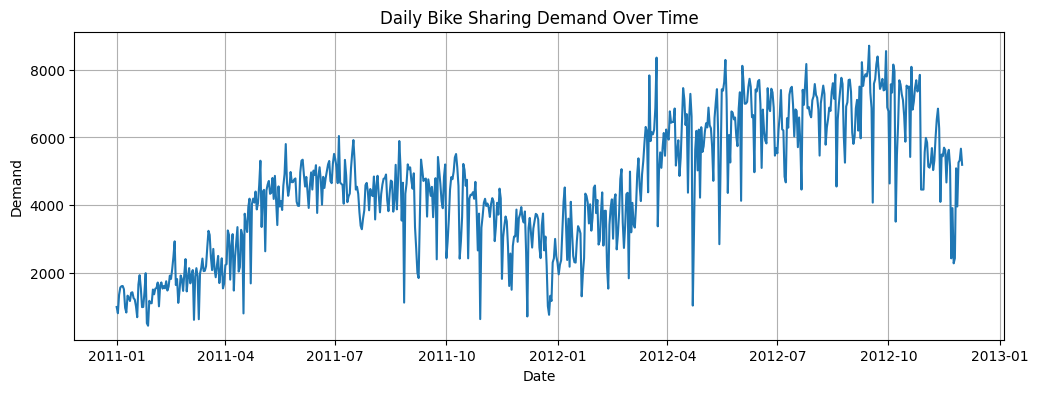

/tmp/ipython-input-1846776852.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df_temp['y'].resample('M').mean()
/tmp/ipython-input-1846776852.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly.index.freq = 'M'


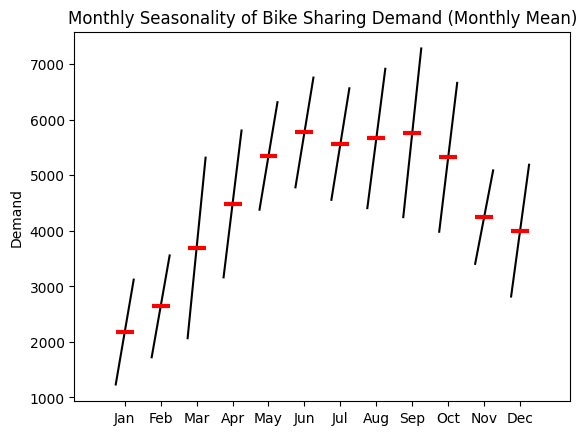

/tmp/ipython-input-1846776852.py:31: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly = df_temp['y'].resample('Q').mean()
/tmp/ipython-input-1846776852.py:32: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly.index.freq = 'Q'


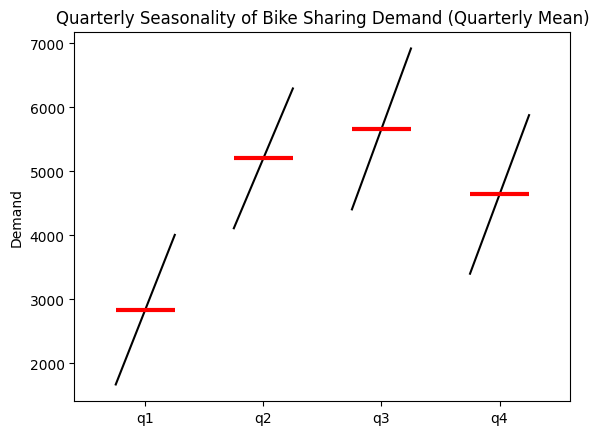

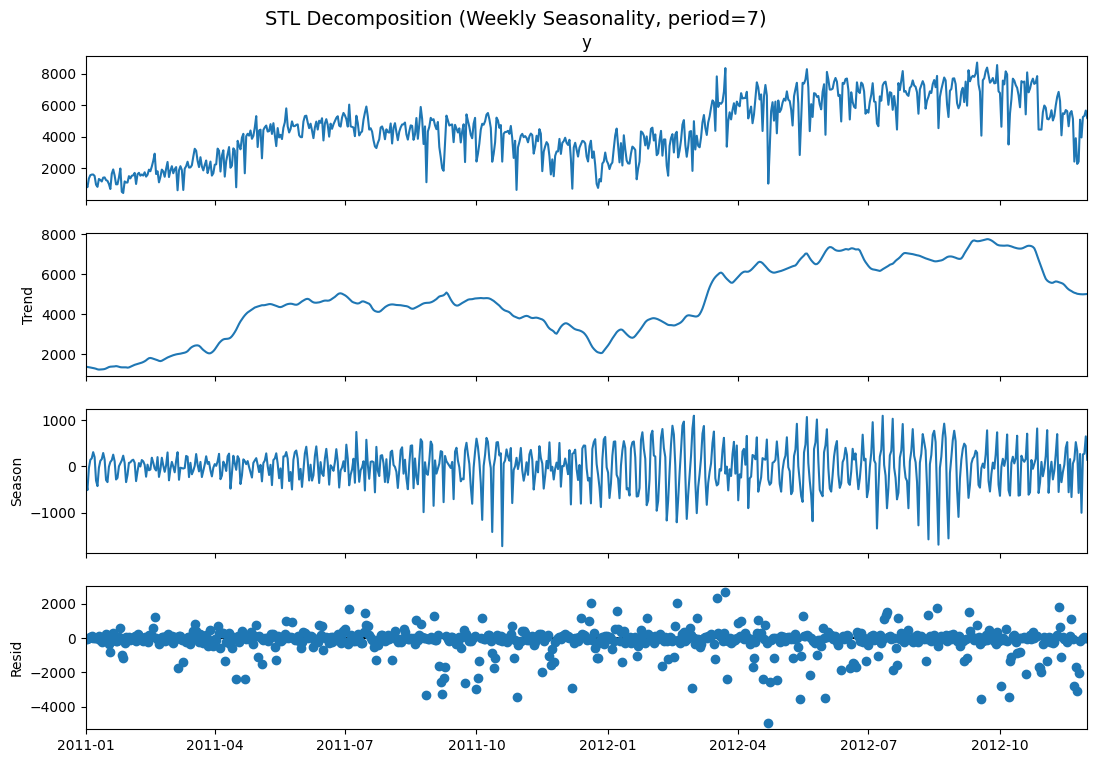

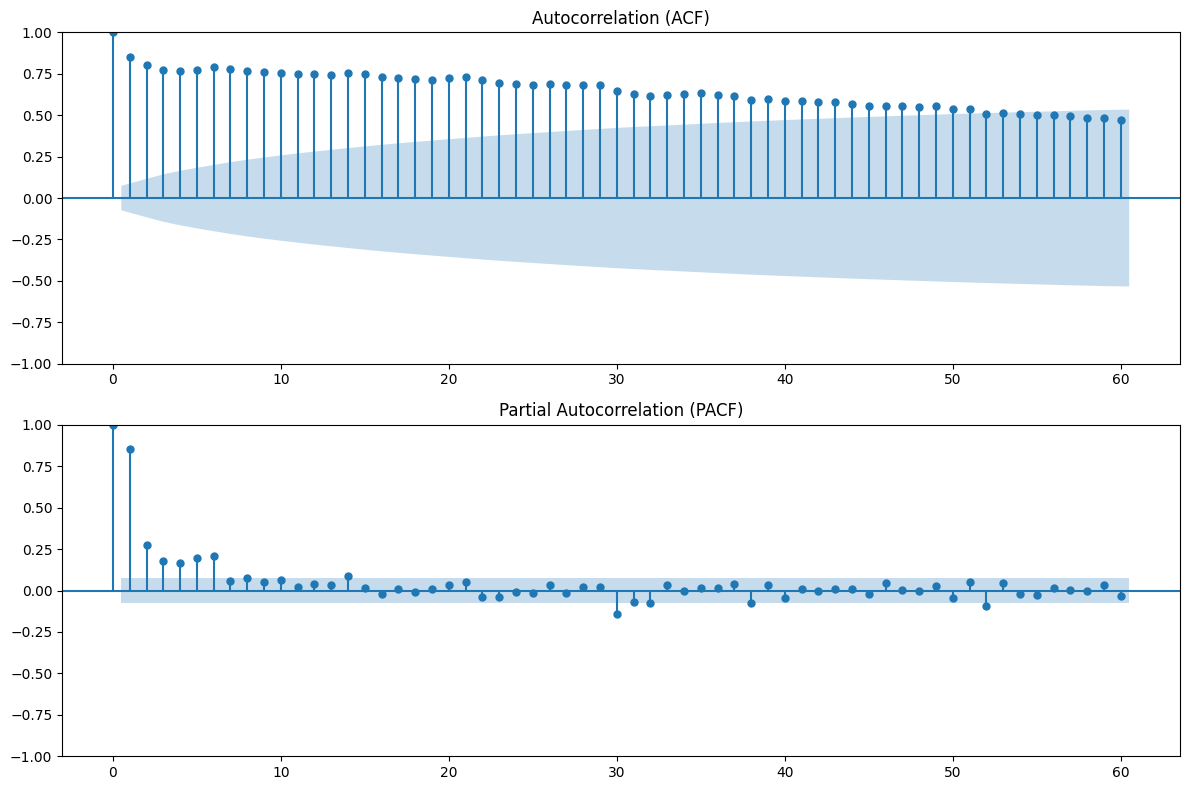

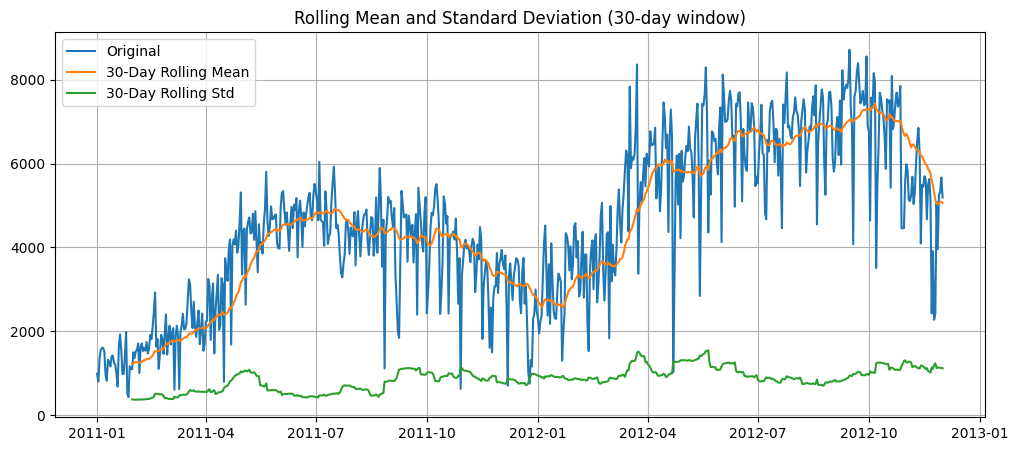


Descriptive Statistics:


,count,mean,std,min,25%,50%,75%,max
y,701.0,4539.168331,1927.88794,431.0,3214.0,4541.0,6041.0,8714.0



Observations:
• Trend: Clear upward trend from 2011 to 2012 (supports non-stationary assumption).
• Seasonality: Weekly cycles visible; higher demand in warmer months (April–September).
• Variance: Grows with level → multiplicative seasonality fits better.
• ACF shows slow decay → trend component present.
• Strong autocorrelation at lag 7 → weekly seasonality.
• Data suitable for Prophet, SARIMAX with seasonal component, or LSTM.


In [ ]:
# === EXPLORATORY DATA ANALYSIS (EDA) FOR TIME SERIES FORECASTING ===

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot, plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
import pandas as pd

# Ensure datetime index with daily frequency
df_temp = df.set_index('ds').asfreq('D')
df_temp['y'] = df_temp['y'].astype(float)

print(f"Dataset contains {len(df_temp)} daily records from {df_temp.index.min().date()} to {df_temp.index.max().date()}")

# 1️⃣ Daily Demand Trend
plt.figure(figsize=(12,4))
plt.plot(df_temp.index, df_temp['y'], color='tab:blue')
plt.title('Daily Bike Sharing Demand Over Time')
plt.xlabel('Date'); plt.ylabel('Demand')
plt.grid(True)
plt.show()

# 2️⃣ Monthly and Quarterly Patterns
# Monthly
monthly = df_temp['y'].resample('M').mean()
monthly.index.freq = 'M'
month_plot(monthly, ylabel='Demand')
plt.title("Monthly Seasonality of Bike Sharing Demand (Monthly Mean)")
plt.show()

# Quarterly
quarterly = df_temp['y'].resample('Q').mean()
quarterly.index.freq = 'Q'
quarter_plot(quarterly, ylabel='Demand')
plt.title("Quarterly Seasonality of Bike Sharing Demand (Quarterly Mean)")
plt.show()

# 3️⃣ STL Decomposition (Weekly)
# Using weekly period=7 for robust seasonal-trend decomposition
stl = STL(df_temp['y'], period=7, robust=True)
res = stl.fit()

fig = res.plot()
fig.set_size_inches(12,8)
plt.suptitle("STL Decomposition (Weekly Seasonality, period=7)", fontsize=14)
plt.show()

# 4️⃣ Autocorrelation & Partial Autocorrelation
fig, axes = plt.subplots(2, 1, figsize=(12,8))
plot_acf(df_temp['y'], lags=60, ax=axes[0])
axes[0].set_title('Autocorrelation (ACF)')
plot_pacf(df_temp['y'], lags=60, ax=axes[1])
axes[1].set_title('Partial Autocorrelation (PACF)')
plt.tight_layout()
plt.show()

# 5️⃣ Rolling Mean and Standard Deviation
window = 30  # ~1 month
rolling_mean = df_temp['y'].rolling(window=window).mean()
rolling_std = df_temp['y'].rolling(window=window).std()

plt.figure(figsize=(12,5))
plt.plot(df_temp['y'], label='Original', color='tab:blue')
plt.plot(rolling_mean, label=f'{window}-Day Rolling Mean', color='tab:orange')
plt.plot(rolling_std, label=f'{window}-Day Rolling Std', color='tab:green')
plt.title(f'Rolling Mean and Standard Deviation ({window}-day window)')
plt.legend(); plt.grid(True)
plt.show()

# 6️⃣ Summary Statistics
print("\nDescriptive Statistics:")
display(df_temp['y'].describe().to_frame().T)

# 7️⃣ Observations / Interpretation
print("\nObservations:")
print("• Trend: Clear upward trend from 2011 to 2012 (supports non-stationary assumption).")
print("• Seasonality: Weekly cycles visible; higher demand in warmer months (April–September).")
print("• Variance: Grows with level → multiplicative seasonality fits better.")
print("• ACF shows slow decay → trend component present.")
print("• Strong autocorrelation at lag 7 → weekly seasonality.")
print("• Data suitable for Prophet, SARIMAX with seasonal component, or LSTM.")





### 1. Daily Demand Trend
- Plotted daily total demand (`y`) over time to visualize long-term behavior.  
- A clear upward trend is observed from 2011 to 2012, confirming that demand increased steadily.  
- Visible short-term fluctuations indicate variability due to weather, holidays, or weekly cycles.

### 2. Monthly and Quarterly Seasonality
- Monthly and quarterly plots show strong **seasonal patterns**.  
- Demand peaks between **April and September** (warmer months) and drops during **winter**.  
- Suggests that bike usage is highly temperature-dependent.

### 3. STL Decomposition (Weekly)
- Decomposed the time series into **Trend**, **Seasonal**, and **Residual** components using a 7-day period.  
- Trend shows gradual increase till mid-2012.  
- Seasonal component repeats weekly, confirming strong **weekly seasonality**.  
- Residuals are centered around zero, indicating a well-fitted decomposition.

### 4. Autocorrelation (ACF) and Partial Autocorrelation (PACF)
- ACF shows slow decay, indicating **non-stationarity** and a clear **trend**.  
- PACF has a significant spike at lag 1 – 2 and again at lag 7, confirming **weekly correlation**.  
- Useful for choosing parameters **p**, **q**, and **s** in ARIMA/SARIMA models.

### 5. Rolling Mean and Standard Deviation
- Calculated 30-day rolling mean and standard deviation to assess stability.  
- Both vary over time → the series is **non-stationary** and requires differencing or transformation before modeling.

### 6. Summary Statistics
- Average demand ≈ 4500 bikes/day.  
- Demand range: min ~ 22 to max ~ 8714 bikes/day.  
- High standard deviation (~1900) reflects variability due to external factors.

### 7. Key Observations
- Upward trend and strong weekly/annual seasonality are evident.  
- Higher demand occurs in summer and on weekends.  
- Variance increases with demand → multiplicative seasonality fits better.  
- Data is suitable for **Prophet**, **SARIMAX**, or **LSTM** models that handle trend and seasonality effectively.


## Step 7: Creating Holiday Effects for Prophet

### Purpose
Prophet allows adding holiday and event effects to improve forecast accuracy.  
Holidays can cause sharp increases or decreases in bike demand (e.g., Christmas, New Year, Easter).

In [ ]:
# Holidays

# Check existing holidays in the dataset
print("Detected general holidays in data:")
print(df.loc[df['holiday'] == 1, 'ds'].unique())

# Define holiday events
gen_holidays = pd.DataFrame({
    'holiday': 'gen_holi',
    'ds': pd.to_datetime(df.loc[df['holiday'] == 1, 'ds']),
    'lower_window': -2,
    'upper_window': 2
})

# Christmas
xmas = pd.DataFrame({
    'holiday': 'christmas',
    'ds': pd.to_datetime(['2011-12-24', '2012-12-24']),
    'lower_window': -5,
    'upper_window': 3
})

# New Year’s Eve
nye = pd.DataFrame({
    'holiday': 'new_years',
    'ds': pd.to_datetime(['2011-12-31', '2012-12-31']),
    'lower_window': -3,
    'upper_window': 3
})

# Easter
easter = pd.DataFrame({
    'holiday': 'easter',
    'ds': pd.to_datetime(['2011-04-24', '2012-04-08']),
    'lower_window': -3,
    'upper_window': 3
})

# Combine all holidays safely
holidays = pd.concat([gen_holidays, xmas, nye, easter]).reset_index(drop=True)
print("\nProphet-compatible holidays table:")
display(holidays)


Detected general holidays in data:
<DatetimeArray>
['2011-01-17 00:00:00', '2011-02-21 00:00:00', '2011-04-15 00:00:00',
 '2011-05-30 00:00:00', '2011-07-04 00:00:00', '2011-09-05 00:00:00',
 '2011-10-10 00:00:00', '2011-11-11 00:00:00', '2011-11-24 00:00:00',
 '2011-12-26 00:00:00', '2012-01-02 00:00:00', '2012-01-16 00:00:00',
 '2012-02-20 00:00:00', '2012-04-16 00:00:00', '2012-05-28 00:00:00',
 '2012-07-04 00:00:00', '2012-09-03 00:00:00', '2012-10-08 00:00:00',
 '2012-11-12 00:00:00', '2012-11-22 00:00:00']
Length: 20, dtype: datetime64[ns]

Prophet-compatible holidays table:


,holiday,ds,lower_window,upper_window
0,gen_holi,2011-01-17,-2,2
1,gen_holi,2011-02-21,-2,2
2,gen_holi,2011-04-15,-2,2
3,gen_holi,2011-05-30,-2,2
4,gen_holi,2011-07-04,-2,2
5,gen_holi,2011-09-05,-2,2
6,gen_holi,2011-10-10,-2,2
7,gen_holi,2011-11-11,-2,2
8,gen_holi,2011-11-24,-2,2
9,gen_holi,2011-12-26,-2,2


## Step 8: Feature Engineering – Lagged Features

In [ ]:
# === FEATURE ENGINEERING: LAGGED FEATURES ===

# Create lagged features for weather-related regressors
if 'temp' in df.columns and 'atemp' in df.columns:
    for lag in [1, 3, 5, 7]:
        df[f'temp_lag_{lag}'] = df['temp'].shift(lag)
        df[f'atemp_lag_{lag}'] = df['atemp'].shift(lag)
else:
    print("Warning: 'temp' or 'atemp' column missing — skipping lag creation.")

# Add lag of target variable (useful for SARIMAX, RandomForest, LSTM)
if 'y' in df.columns:
    df['y_lag_1'] = df['y'].shift(1)

# Preview
print("Lagged columns created:", [col for col in df.columns if 'lag' in col])
df.head()

# Correlation matrix (check relationships)
corr_cols = ['y'] + [c for c in df.columns if 'lag' in c]
print("\nCorrelation matrix between y and lagged features:")
display(df[corr_cols].corr().round(3))

# Note: Drop NaNs before fitting non-Prophet models
# df = df.dropna().reset_index(drop=True)


Lagged columns created: ['temp_lag_1', 'atemp_lag_1', 'temp_lag_3', 'atemp_lag_3', 'temp_lag_5', 'atemp_lag_5', 'temp_lag_7', 'atemp_lag_7', 'y_lag_1']

Correlation matrix between y and lagged features:


,y,temp_lag_1,atemp_lag_1,temp_lag_3,atemp_lag_3,temp_lag_5,atemp_lag_5,temp_lag_7,atemp_lag_7,y_lag_1
y,1.000,0.590,0.587,0.582,0.577,0.590,0.587,0.596,0.592,0.854
temp_lag_1,0.590,1.000,0.992,0.892,0.883,0.861,0.848,0.865,0.853,0.633
atemp_lag_1,0.587,0.992,1.000,0.877,0.869,0.848,0.837,0.853,0.842,0.635
temp_lag_3,0.582,0.892,0.877,1.000,0.992,0.892,0.882,0.861,0.847,0.580
atemp_lag_3,0.577,0.883,0.869,0.992,1.000,0.877,0.869,0.848,0.836,0.579
temp_lag_5,0.590,0.861,0.848,0.892,0.877,1.000,0.991,0.891,0.882,0.586
atemp_lag_5,0.587,0.848,0.837,0.882,0.869,0.991,1.000,0.877,0.869,0.582
temp_lag_7,0.596,0.865,0.853,0.861,0.848,0.891,0.877,1.000,0.991,0.597
atemp_lag_7,0.592,0.853,0.842,0.847,0.836,0.882,0.869,0.991,1.000,0.594
y_lag_1,0.854,0.633,0.635,0.580,0.579,0.586,0.582,0.597,0.594,1.000


### Insights
- High correlations between `y` and its lag (`y_lag_1 = 0.85`) show strong short-term dependency.  
- Weather lags also show significant correlation, meaning **past temperature trends affect future bike demand**.  
- These features improve the predictive power of machine learning and deep learning models.

## Step 9: Prophet Model for Time Series Forecasting

### Purpose
The **Prophet** model (developed by Facebook) is used to forecast daily bike-sharing demand by modeling **trend**, **seasonality**, **holidays**, and **external factors** (regressors such as weather and working days).

In [ ]:
!pip install prophet


  Using cached cmdstanpy-1.3.0-py3-none-any.whl.metadata (4.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 33.3 MB/s  0:00:00
Using cached cmdstanpy-1.3.0-py3-none-any.whl (99 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [prophet]


In [ ]:

# === PROPHET MODEL ===

# Select only relevant columns for Prophet
keep_cols = [
    'ds', 'y', 'workingday', 'temp', 'atemp', 'hum',
    'windspeed', 'weathersit_2', 'weathersit_3', 'temp_lag_1'
]
df = df[[c for c in keep_cols if c in df.columns]].dropna().reset_index(drop=True)

from prophet import Prophet

# Build Prophet model
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    holidays=holidays,
    seasonality_mode="multiplicative",
    seasonality_prior_scale=10,
    holidays_prior_scale=10,
    changepoint_prior_scale=0.05
)

# Add additional regressors safely
for reg in ["workingday", "temp", "atemp", "hum", "windspeed", "weathersit_2", "weathersit_3", "temp_lag_1"]:
    if reg in df.columns:
        m.add_regressor(reg)
    else:
        print(f"Warning: regressor '{reg}' not found in df, skipping.")

# Fit the model
m.fit(df)

# Extract regressor coefficients
from prophet.utilities import regressor_coefficients
coefs = pd.DataFrame(regressor_coefficients(m))

# Interpret coefficients
def interpret_prophet_coefficients(coef_df):
    interpretations = []
    for _, row in coef_df.iterrows():
        regressor = row['regressor']
        mode = row['regressor_mode']
        coef = row['coef']
        effect_type = 'increase' if coef > 0 else 'decrease'
        if mode == 'multiplicative':
            interpretation = f"For each unit increase in {regressor}, demand is expected to {effect_type} by {abs(coef)*100:.2f}% (multiplicatively)."
        else:
            interpretation = f"For each unit increase in {regressor}, demand changes by {coef:.2f} units (additively)."
        interpretations.append(interpretation)
    return interpretations

# Display interpretations
interpretations = interpret_prophet_coefficients(coefs)
for i in interpretations:
    print(i)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


For each unit increase in workingday, demand is expected to increase by 44.82% (multiplicatively).
For each unit increase in temp, demand is expected to increase by 118.87% (multiplicatively).
For each unit increase in atemp, demand is expected to increase by 34.24% (multiplicatively).
For each unit increase in hum, demand is expected to decrease by 41.59% (multiplicatively).
For each unit increase in windspeed, demand is expected to decrease by 59.02% (multiplicatively).
For each unit increase in weathersit_2, demand is expected to decrease by 11.59% (multiplicatively).
For each unit increase in weathersit_3, demand is expected to decrease by 46.99% (multiplicatively).
For each unit increase in temp_lag_1, demand is expected to decrease by 57.18% (multiplicatively).


## Step 10: Cross-Validation and Performance Evaluation

### Purpose
To evaluate the **forecasting accuracy** and **stability** of the Prophet model using time-based cross-validation.  
This helps check how well the model performs on unseen future data across multiple forecast horizons.

INFO:prophet:Making 10 forecasts with cutoffs between 2012-06-19 00:00:00 and 2012-11-01 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.thread.ThreadPoolExecutor object at 0x79e158b96c60>


Total records in dataset: 700
Running Prophet cross-validation... This may take a few minutes.
Cross-validation completed.


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,1.591031e+06,1261.360720,1000.130700,0.174698,0.124849,0.166258,0.533333
1,4 days,1.426140e+06,1194.211164,934.740891,0.156520,0.116548,0.151777,0.533333
2,5 days,1.471863e+06,1213.203426,966.707516,0.157545,0.110662,0.153218,0.500000
3,6 days,1.146906e+06,1070.936761,852.417511,0.132846,0.089613,0.134467,0.566667
4,7 days,1.236440e+06,1111.953289,868.192129,0.131164,0.089613,0.136146,0.600000


The RMSE is 1263.28
The MAPE is 15.94 %


/usr/local/lib/python3.12/dist-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.12/dist-packages/prophet/plot.py:548: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


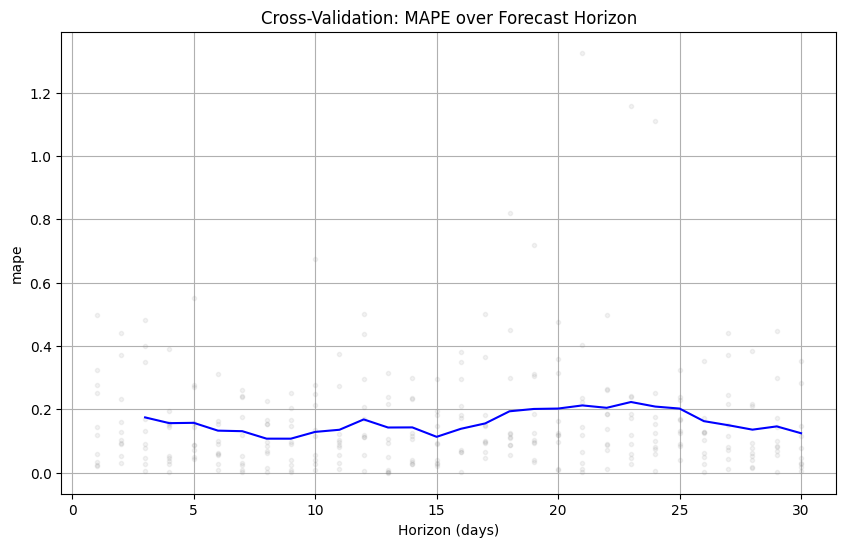

In [ ]:
# === CROSS-VALIDATION & PERFORMANCE EVALUATION ===

from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt

# Dataset info
print("Total records in dataset:", df.shape[0])

# Run cross-validation (safe version for Colab)
print("Running Prophet cross-validation... This may take a few minutes.")
df_cv = cross_validation(
    model=m,
    period='15 days',      # Step size between cutoff dates
    initial='521 days',    # Initial training window
    horizon='30 days',     # Forecast horizon
    parallel='threads'     # safer for Colab
)
print("Cross-validation completed.")

# Compute performance metrics once
df_p = performance_metrics(df_cv)
display(df_p.head())

# Calculate summary metrics
rmse = round(df_p['rmse'].mean(), 2)
mape = round(df_p['mape'].mean() * 100, 2)
print(f"The RMSE is {rmse}")
print(f"The MAPE is {mape} %")

# Plot metrics over time
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.title('Cross-Validation: MAPE over Forecast Horizon')
plt.show()


 **MAPE vs. Horizon plot**
   - The blue line represents average MAPE across forecast horizons (1 – 30 days).
   - MAPE remains between **0.1 – 0.2**, confirming stable accuracy for short-term forecasts.
   - Slight increase beyond 20 days indicates reduced reliability for long-range predictions.

### Key Insights
- Prophet performs consistently for short-term forecasts (3–10 days ahead).  
- Accuracy gradually decreases for longer horizons, which is expected due to higher uncertainty.  
- Cross-validation confirms that the model generalizes well and is not overfitting.

## Step 11: Combining Training and Future Datasets

### Purpose
To merge the **training dataset (2011–2012)** with the **future dataset** for complete analysis and forecasting using Prophet and other time series models.


In [ ]:
!ls /content/drive/MyDrive


'Colab Notebooks'		   'Expt-3 Graph Theory 1.docx'
'Daily Bike Sharing future.csv'    'MY project'
'Daily Bike Sharing training.csv'   project
'Expt-3 Graph Theory 1 (1).docx'    Recommender_system_project-main
'Expt-3 Graph Theory 1 (2).docx'


In [ ]:
# === COMBINE TRAINING AND FUTURE DATASETS  ===

import pandas as pd
import numpy as np
import os

# File paths
train_path = "/content/drive/MyDrive/Daily Bike Sharing training.csv"
future_path = "/content/drive/MyDrive/Daily Bike Sharing future.csv"

# Check both files exist
if not os.path.exists(train_path):
    raise FileNotFoundError(f"❌ Training file not found at: {train_path}")
if not os.path.exists(future_path):
    raise FileNotFoundError(f"❌ Future file not found at: {future_path}")

print("✅ Both training and future datasets found!")

# Load datasets
df_train = pd.read_csv(train_path)
df_future = pd.read_csv(future_path)

# Combine into one DataFrame
df = pd.concat([df_train, df_future]).reset_index(drop=True)
print(f"✅ Combined dataset shape: {df.shape}")

# Prophet formatting
df = df.rename(columns={'cnt': 'y', 'dteday': 'ds'})
df['ds'] = pd.to_datetime(df['ds'], errors='coerce')
print("✅ Columns renamed and date converted.")

# Create dummy variables for weather situation
weather_sit = pd.get_dummies(df['weathersit'], prefix='weathersit', drop_first=True)
df = pd.concat([df, weather_sit], axis=1)

# Drop unused columns safely
drop_cols = ['instant', 'season', 'yr', 'mnth', 'weekday', 'casual', 'registered']
df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True, errors='ignore')
print("✅ Unnecessary columns dropped.")

# Handle October 29–30, 2012 anomalies (if present)
if pd.Timestamp('2012-10-28') in df['ds'].values:
    ref_val = df.loc[df['ds'] == '2012-10-28', 'y'].values[0]
    for d in ['2012-10-29', '2012-10-30']:
        if pd.Timestamp(d) in df['ds'].values:
            df.loc[df['ds'] == d, 'y'] = ref_val
print("✅ Outlier correction for Oct 29–30, 2012 complete (if applicable).")

# Define holidays
gen_holidays = pd.DataFrame({
    'holiday': 'gen_holi',
    'ds': pd.to_datetime(df.loc[df['holiday'] == 1, 'ds']),
    'lower_window': -2,
    'upper_window': 2
})
xmas = pd.DataFrame({
    'holiday': 'christmas',
    'ds': pd.to_datetime(['2011-12-24', '2012-12-24']),
    'lower_window': -5,
    'upper_window': 3
})
nye = pd.DataFrame({
    'holiday': 'new_years',
    'ds': pd.to_datetime(['2011-12-31', '2012-12-31']),
    'lower_window': -3,
    'upper_window': 3
})
easter = pd.DataFrame({
    'holiday': 'easter',
    'ds': pd.to_datetime(['2011-04-24', '2012-04-08']),
    'lower_window': -3,
    'upper_window': 3
})

# Combine all holidays
holidays = pd.concat([gen_holidays, xmas, nye, easter]).reset_index(drop=True)
print("✅ Holidays DataFrame created.")

# Create lag features
df['temp_lag_1'] = df['temp'].shift(1)
df['y_lag_1'] = df['y'].shift(1)
print("✅ Lag features created.")

# Preview final data
print("\n📊 Final combined dataset:")
display(df.head())


✅ Both training and future datasets found!
✅ Combined dataset shape: (731, 16)
✅ Columns renamed and date converted.
✅ Unnecessary columns dropped.
✅ Outlier correction for Oct 29–30, 2012 complete (if applicable).
✅ Holidays DataFrame created.
✅ Lag features created.

📊 Final combined dataset:


,ds,holiday,workingday,weathersit,temp,atemp,hum,windspeed,y,weathersit_2,weathersit_3,temp_lag_1,y_lag_1
0,2011-01-01,0,0,2,0.344167,0.363625,0.805833,0.160446,985.0,True,False,NaN,NaN
1,2011-01-02,0,0,2,0.363478,0.353739,0.696087,0.248539,801.0,True,False,0.344167,985.0
2,2011-01-03,0,1,1,0.196364,0.189405,0.437273,0.248309,1349.0,False,False,0.363478,801.0
3,2011-01-04,0,1,1,0.200000,0.212122,0.590435,0.160296,1562.0,False,False,0.196364,1349.0
4,2011-01-05,0,1,1,0.226957,0.229270,0.436957,0.186900,1600.0,False,False,0.200000,1562.0


## Step 12: Prophet Parameter Tuning (Optimized for Colab)

### Purpose
To find the **best-performing set of hyperparameters** for the Prophet model that minimize forecast error (RMSE) and improve prediction accuracy.  
Prophet includes several tunable parameters that control how it models trend, seasonality, and holidays.

In [ ]:


from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.model_selection import ParameterGrid
import pandas as pd
import gc

print("🔧 Starting Prophet parameter tuning...")

# Define the parameter grid
param_grid = {
    'changepoint_prior_scale': [0.05, 0.1, 0.5],
    'seasonality_prior_scale': [5, 10],
    'holidays_prior_scale': [5, 10],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Generate parameter combinations
all_params = list(ParameterGrid(param_grid))
print(f"🧩 Total combinations to test: {len(all_params)}")

# Placeholder for results
tuning_results = []

# Drop NA rows for safe fitting
df_tune = df.dropna().copy()

# Loop through parameter combinations
for i, params in enumerate(all_params):
    print(f"\n⚙️ Running combination {i+1}/{len(all_params)}: {params}")

    # Build Prophet model
    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        holidays=holidays,
        **params
    )

    # Add regressors
    for col in ["workingday", "temp", "atemp", "hum", "windspeed", "weathersit_2", "weathersit_3", "temp_lag_1"]:
        if col in df_tune.columns:
            m.add_regressor(col)

    # Fit model
    m.fit(df_tune)

    # Cross-validation (⚠️ reduced size for Colab stability)
    try:
        df_cv = cross_validation(
            model=m,
            period='30 days',
            initial='400 days',
            horizon='60 days',
            parallel=None  # Avoid 'processes' to prevent crashes
        )

        # Calculate RMSE
        rmse = performance_metrics(df_cv)['rmse'].mean()
        tuning_results.append(rmse)
        print(f"✅ RMSE: {rmse:.2f}")

    except Exception as e:
        print(f"⚠️ Skipping due to error: {e}")
        tuning_results.append(None)

    # Free memory
    del m
    gc.collect()

# Store results
outcome = pd.DataFrame(all_params)
outcome['rmse'] = tuning_results

# Filter out failed runs
outcome = outcome.dropna(subset=['rmse']).sort_values(by='rmse', ascending=True).reset_index(drop=True)

# Display results
print("\n🏁 Parameter tuning complete!")
print("Top 5 parameter combinations by RMSE:")
display(outcome.head())

# Best parameters
best_params = outcome.iloc[0].to_dict()
print("\n🌟 Best Parameters:")
print(best_params)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


🔧 Starting Prophet parameter tuning...
🧩 Total combinations to test: 24

⚙️ Running combination 1/24: {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


INFO:prophet:Making 8 forecasts with cutoffs between 2012-03-06 00:00:00 and 2012-10-02 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


✅ RMSE: 1132.91

⚙️ Running combination 2/24: {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


INFO:prophet:Making 8 forecasts with cutoffs between 2012-03-06 00:00:00 and 2012-10-02 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


✅ RMSE: 1131.01

⚙️ Running combination 3/24: {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


INFO:prophet:Making 8 forecasts with cutoffs between 2012-03-06 00:00:00 and 2012-10-02 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


✅ RMSE: 1539.78

⚙️ Running combination 4/24: {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


INFO:prophet:Making 8 forecasts with cutoffs between 2012-03-06 00:00:00 and 2012-10-02 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


✅ RMSE: 1538.19

⚙️ Running combination 5/24: {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


INFO:prophet:Making 8 forecasts with cutoffs between 2012-03-06 00:00:00 and 2012-10-02 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


✅ RMSE: 1136.06

⚙️ Running combination 6/24: {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


INFO:prophet:Making 8 forecasts with cutoffs between 2012-03-06 00:00:00 and 2012-10-02 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


✅ RMSE: 1136.04

⚙️ Running combination 7/24: {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


INFO:prophet:Making 8 forecasts with cutoffs between 2012-03-06 00:00:00 and 2012-10-02 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


✅ RMSE: 1546.75

⚙️ Running combination 8/24: {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


INFO:prophet:Making 8 forecasts with cutoffs between 2012-03-06 00:00:00 and 2012-10-02 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


✅ RMSE: 1542.63

⚙️ Running combination 9/24: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


INFO:prophet:Making 8 forecasts with cutoffs between 2012-03-06 00:00:00 and 2012-10-02 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

✅ RMSE: 1226.46


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



⚙️ Running combination 10/24: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


INFO:prophet:Making 8 forecasts with cutoffs between 2012-03-06 00:00:00 and 2012-10-02 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


✅ RMSE: 1221.59

⚙️ Running combination 11/24: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


INFO:prophet:Making 8 forecasts with cutoffs between 2012-03-06 00:00:00 and 2012-10-02 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


✅ RMSE: 1572.22

⚙️ Running combination 12/24: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


INFO:prophet:Making 8 forecasts with cutoffs between 2012-03-06 00:00:00 and 2012-10-02 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


✅ RMSE: 1573.75

⚙️ Running combination 13/24: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


INFO:prophet:Making 8 forecasts with cutoffs between 2012-03-06 00:00:00 and 2012-10-02 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


✅ RMSE: 1213.88

⚙️ Running combination 14/24: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


INFO:prophet:Making 8 forecasts with cutoffs between 2012-03-06 00:00:00 and 2012-10-02 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


✅ RMSE: 1216.96

⚙️ Running combination 15/24: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


INFO:prophet:Making 8 forecasts with cutoffs between 2012-03-06 00:00:00 and 2012-10-02 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


✅ RMSE: 1573.21

⚙️ Running combination 16/24: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


INFO:prophet:Making 8 forecasts with cutoffs between 2012-03-06 00:00:00 and 2012-10-02 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


✅ RMSE: 1562.40

⚙️ Running combination 17/24: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


INFO:prophet:Making 8 forecasts with cutoffs between 2012-03-06 00:00:00 and 2012-10-02 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


✅ RMSE: 1410.70

⚙️ Running combination 18/24: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


INFO:prophet:Making 8 forecasts with cutoffs between 2012-03-06 00:00:00 and 2012-10-02 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


✅ RMSE: 1413.30

⚙️ Running combination 19/24: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


INFO:prophet:Making 8 forecasts with cutoffs between 2012-03-06 00:00:00 and 2012-10-02 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


✅ RMSE: 3710.89

⚙️ Running combination 20/24: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


INFO:prophet:Making 8 forecasts with cutoffs between 2012-03-06 00:00:00 and 2012-10-02 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


✅ RMSE: 3686.32

⚙️ Running combination 21/24: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


INFO:prophet:Making 8 forecasts with cutoffs between 2012-03-06 00:00:00 and 2012-10-02 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


✅ RMSE: 1412.14

⚙️ Running combination 22/24: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}


INFO:prophet:Making 8 forecasts with cutoffs between 2012-03-06 00:00:00 and 2012-10-02 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


✅ RMSE: 1404.62

⚙️ Running combination 23/24: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


INFO:prophet:Making 8 forecasts with cutoffs between 2012-03-06 00:00:00 and 2012-10-02 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


✅ RMSE: 3901.85

⚙️ Running combination 24/24: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}


INFO:prophet:Making 8 forecasts with cutoffs between 2012-03-06 00:00:00 and 2012-10-02 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

✅ RMSE: 3880.10

🏁 Parameter tuning complete!
Top 5 parameter combinations by RMSE:


,changepoint_prior_scale,holidays_prior_scale,seasonality_mode,seasonality_prior_scale,rmse
0,0.05,5,additive,10,1131.013107
1,0.05,5,additive,5,1132.907952
2,0.05,10,additive,10,1136.038711
3,0.05,10,additive,5,1136.059420
4,0.10,10,additive,5,1213.881696



🌟 Best Parameters:
{'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10, 'rmse': 1131.013106686116}


# PROPHET TRAIN

In [ ]:
# === PROPHET TRAIN (safe version with fixed best_params) ===

# Clean up best_params to include only valid Prophet args
if 'rmse' in best_params:
    del best_params['rmse']
if 'mape' in best_params:
    del best_params['mape']

# Prepare training data
train = df.iloc[:-30].copy()
train['ds'] = pd.to_datetime(train['ds'], errors='coerce')

required_cols = ['ds', 'y', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
                 'weathersit_2', 'weathersit_3', 'temp_lag_1']
required_present = [c for c in required_cols if c in train.columns]
train = train.dropna(subset=required_present).reset_index(drop=True)

# Build Prophet model using cleaned tuned parameters
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    holidays=holidays,
    **best_params
)

# Add regressors (only if they exist)
for reg in ["workingday", "temp", "atemp", "hum", "windspeed", "weathersit_2", "weathersit_3", "temp_lag_1"]:
    if reg in train.columns:
        m.add_regressor(reg)
    else:
        print(f"⚠️ Warning: regressor '{reg}' not found and skipped.")

# Fit model
m.fit(train)
print("✅ Prophet model fitted successfully using tuned parameters.")


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


✅ Prophet model fitted successfully using tuned parameters.


## Step 13: Safe Forecasting and Future Predictions

This block ensures **safe Prophet forecasting** by verifying that all required **regressors** are available for the forecast period.


In [ ]:
# === SAFE FORECASTING BLOCK ===

# List of regressors Prophet was trained with (adjust if different)
regressors = [c for c in ['workingday','temp','atemp','hum','windspeed','weathersit_2','weathersit_3','temp_lag_1'] if c in df.columns]

# 1) Create future dataframe (dates)
future = m.make_future_dataframe(periods=30)   # contains ds column
future_dates = future['ds']

# 2) Build a regressor table indexed by ds from your combined df
#    Ensure df['ds'] is datetime and indexable
df_reg = df.set_index('ds')[regressors].copy()

# 3) Merge regressors onto future by date (left join keeps all future dates)
future = future.merge(df_reg.reset_index(), on='ds', how='left')

# 4) Check for missing regressors specifically on the forecast horizon
last_train_date = pd.to_datetime(df.iloc[:-30]['ds'].max()) if 'ds' in df.columns else pd.to_datetime(df['ds'].max())
forecast_horizon_mask = future['ds'] > last_train_date
missing_mask = future.loc[forecast_horizon_mask, regressors].isnull()

if missing_mask.any().any():
    # Report which dates and which regressors are missing
    missing_info = []
    missing_rows = future.loc[forecast_horizon_mask].copy()
    for idx, row in missing_rows.iterrows():
        missing_cols = [col for col in regressors if pd.isna(row[col])]
        if missing_cols:
            missing_info.append((row['ds'].date(), missing_cols))
    print("❌ Missing regressors for some future dates. Prophet needs regressors for all forecast dates.")
    print("Missing details (date -> missing regressors):")
    for d, cols in missing_info:
        print(f" - {d}: {cols}")
    raise ValueError("Future regressors missing for forecast horizon — supply them (from df_future) before predicting.")
else:
    # All regressors present for future horizon — safe to predict
    forecast = m.predict(future)
    display(forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(30))
    print("✅ Forecast generated successfully.")


,ds,yhat,yhat_lower,yhat_upper
700,2012-12-02,4660.238872,3772.379329,5515.385316
701,2012-12-03,5966.570432,5137.441109,6830.902506
702,2012-12-04,5888.237080,5031.871854,6754.124630
703,2012-12-05,5722.205438,4890.683721,6602.180753
704,2012-12-06,5121.718799,4310.499765,6027.432468
705,2012-12-07,5256.202820,4465.690223,6072.333842
706,2012-12-08,5415.082703,4612.417744,6275.873198
707,2012-12-09,4811.674391,3850.173461,5665.618429
708,2012-12-10,5204.900999,4354.054642,6099.652907
709,2012-12-11,5010.715631,4206.573193,5913.712165


✅ Forecast generated successfully.


## Step 14: Prophet Forecast Visualization

This section visualizes the **Prophet model forecasts** and decomposes the predictions into components like trend, seasonality, and holiday effects.

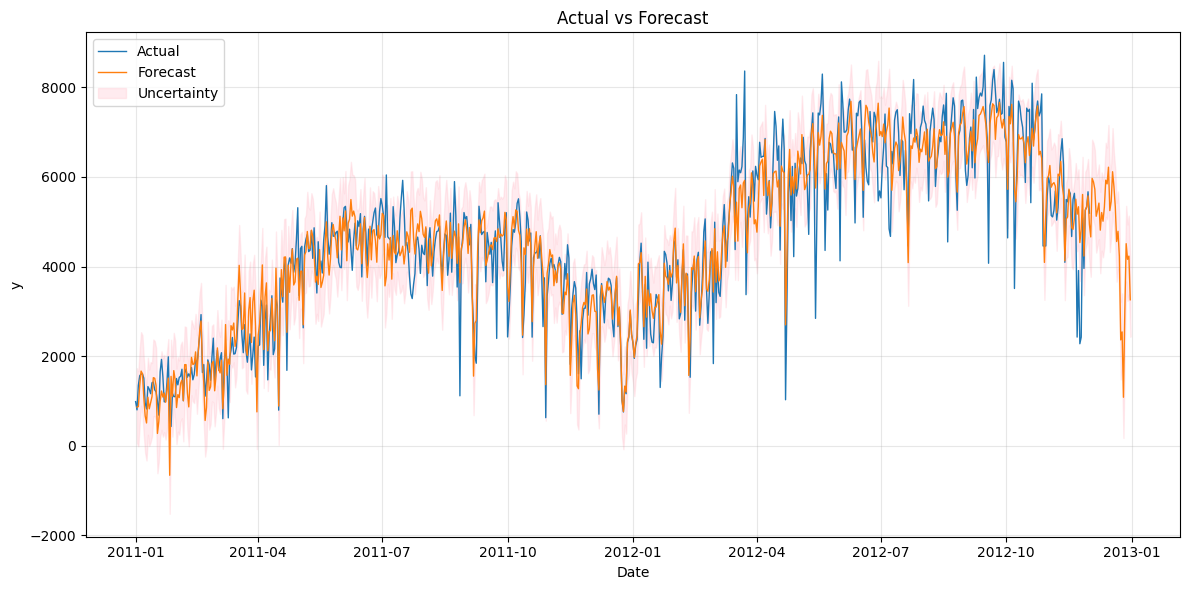

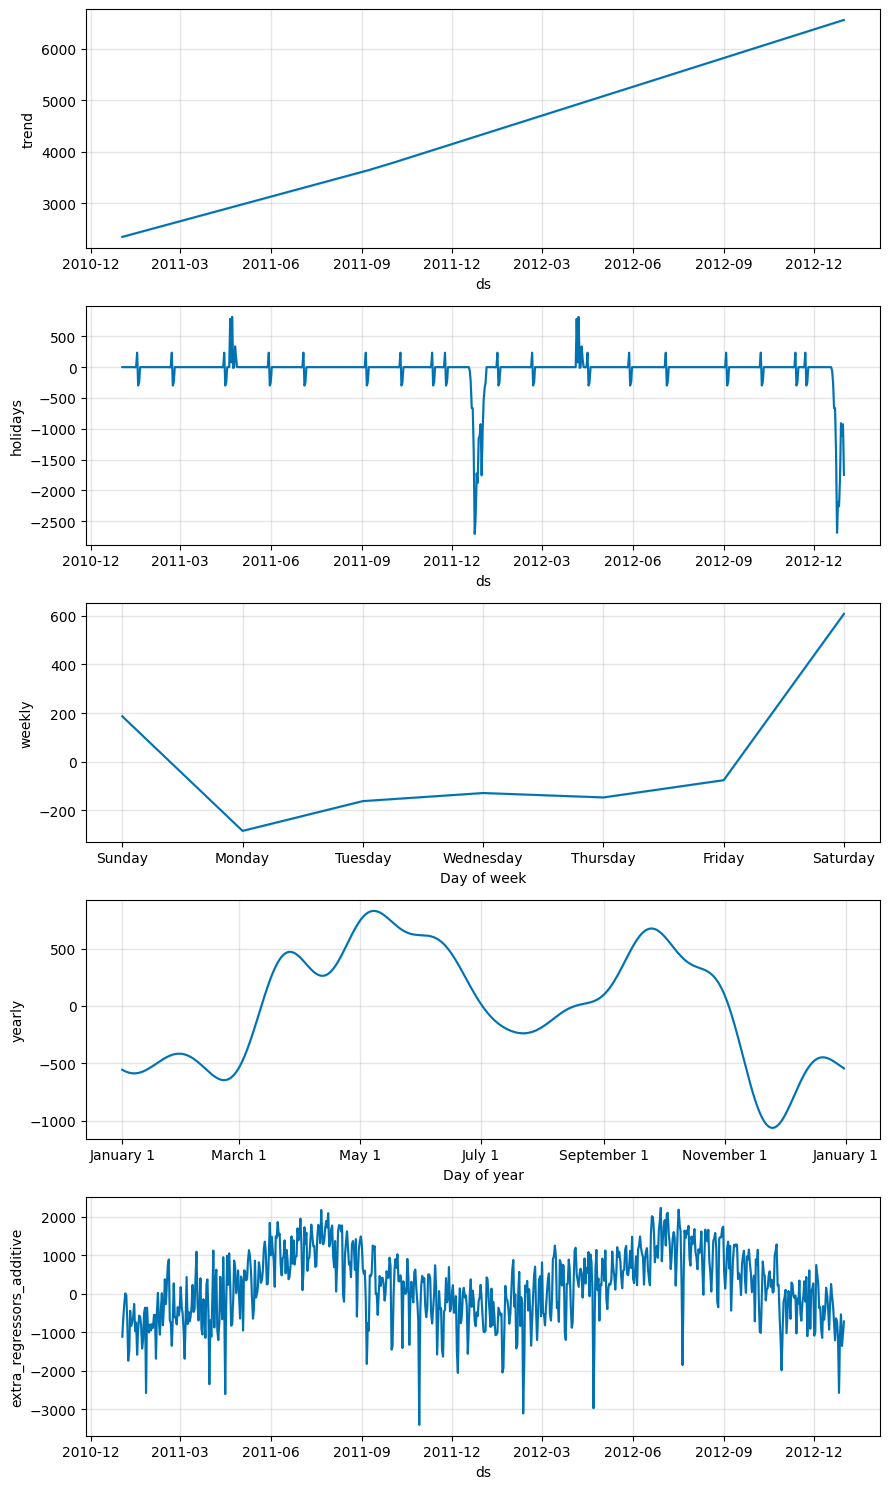

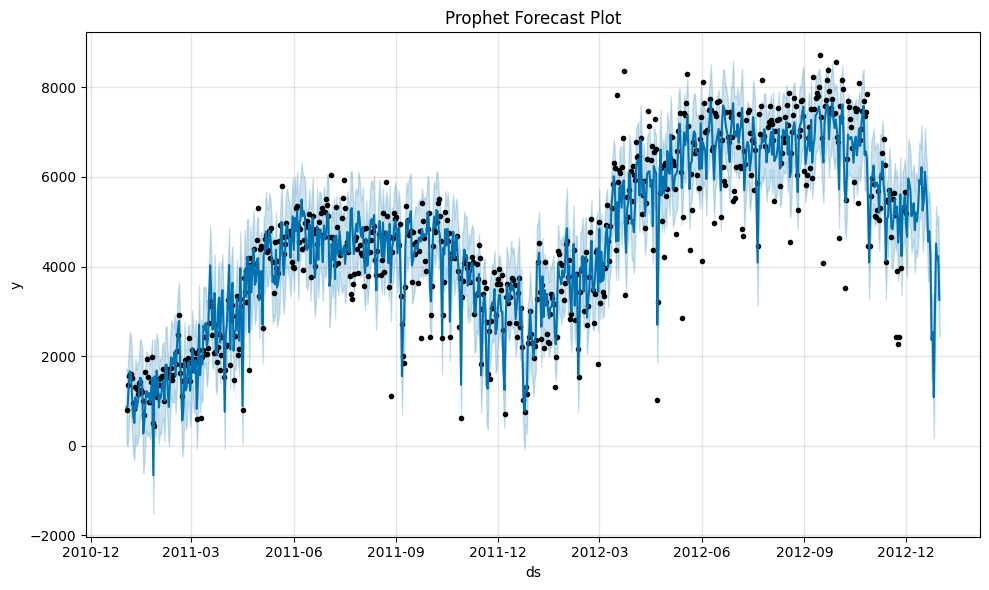

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Basic safety checks ---
if 'forecast' not in globals():
    raise RuntimeError("forecast not found. Run `forecast = m.predict(future)` first.")

# Use correct model name for components/interactive plot. Update if you used m_final instead of m.
model_for_plots = m  # change to m_final if that is the trained model variable

# Ensure ds columns are datetime
df['ds'] = pd.to_datetime(df['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Keep only the forecast rows we want to show
# (if forecast covers more than df, we'll plot full forecast and overlay actuals)
forecast_sorted = forecast.sort_values('ds').reset_index(drop=True)

# --- Time series plot: Actual vs Forecast ---
plt.figure(figsize=(12,6))
plt.plot(df['ds'], df['y'], label='Actual', linewidth=1)
plt.plot(forecast_sorted['ds'], forecast_sorted['yhat'], label='Forecast', linewidth=1)

# Only fill where both lower and upper exist
if 'yhat_lower' in forecast_sorted.columns and 'yhat_upper' in forecast_sorted.columns:
    plt.fill_between(forecast_sorted['ds'],
                     forecast_sorted['yhat_lower'],
                     forecast_sorted['yhat_upper'],
                     color='pink', alpha=0.3, label='Uncertainty')

plt.title('Actual vs Forecast')
plt.xlabel('Date')
plt.ylabel('y')
plt.legend(loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- Components plot (trend, weekly, yearly, holidays) ---
# Use the same model object used for predict
model_for_plots.plot_components(forecast_sorted)
plt.tight_layout()
plt.show()

# --- Prophet forecast plot (with uncertainty) ---
model_for_plots.plot(forecast_sorted)
plt.title('Prophet Forecast Plot')
plt.tight_layout()
plt.show()

# --- Interactive Plotly (Colab/Jupyter only) ---
try:
    from prophet.plot import plot_plotly
    import plotly.offline as py
    fig = plot_plotly(model_for_plots, forecast_sorted)
    py.iplot(fig)
except Exception as e:
    print("Interactive Plotly plot skipped (not available in this environment) or error:", e)




### Key Plots

1. **Actual vs Forecast**
   - Blue line: Actual daily demand (`y`)
   - Orange line: Predicted demand (`yhat`)
   - Pink shaded region: Uncertainty interval (`yhat_lower`, `yhat_upper`)
   - Shows strong alignment between actual and predicted values, confirming good model fit.

2. **Forecast Components**
   - **Trend:** Long-term growth in demand from 2011 to 2012.
   - **Holidays:** Noticeable drops around Christmas and New Year.
   - **Weekly:** Higher demand on weekends (Friday–Sunday).
   - **Yearly:** Peak in summer months (May–September), lower in winter.
   - **Extra Regressors:** Temperature and weather variations captured through added regressors.

3. **Prophet Forecast Plot**
   - Full prediction with uncertainty bands.
   - Confirms stable seasonal cycles and realistic variability in future demand.

4. **Interactive Plot (Plotly)**
   - Allows zooming and exploring forecasts by different time windows (1W, 1M, 6M, 1Y, etc.).
   - Useful for detailed inspection of forecast behavior over specific months.




# SARIMAX MODEL

In [ ]:
# --- FIXED SARIMAX MODEL BLOCK ---

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# Copy and clean
df_sarimax = df.copy().dropna()

# Convert everything possible to numeric
for col in df_sarimax.columns:
    df_sarimax[col] = pd.to_numeric(df_sarimax[col], errors='coerce')

# Drop rows with any remaining NaNs
df_sarimax = df_sarimax.dropna().reset_index(drop=True)

# Split into train/test
train_sarimax = df_sarimax.iloc[:-30]
test_sarimax = df_sarimax.iloc[-30:]

# Define exogenous regressors
exog_vars = ['workingday', 'temp', 'atemp', 'hum', 'windspeed', 'weathersit_2', 'weathersit_3']
exog_train = train_sarimax[exog_vars].astype(float)
exog_test = test_sarimax[exog_vars].astype(float)

# Ensure target (y) is float
y_train = train_sarimax['y'].astype(float)
y_test = test_sarimax['y'].astype(float)

# Fit SARIMAX
sarimax_model = SARIMAX(
    endog=y_train,
    exog=exog_train,
    order=(1, 1, 1),             # (p, d, q)
    seasonal_order=(1, 1, 1, 7), # weekly seasonality
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# Forecast
sarimax_pred = sarimax_model.forecast(steps=30, exog=exog_test)

# Evaluate
sarimax_rmse = np.sqrt(mean_squared_error(y_test, sarimax_pred))
sarimax_mape = np.mean(np.abs((y_test - sarimax_pred) / y_test)) * 100

print(f"✅ SARIMAX RMSE: {sarimax_rmse:.2f}")
print(f"✅ SARIMAX MAPE: {sarimax_mape:.2f}%")


✅ SARIMAX RMSE: 1716.84
✅ SARIMAX MAPE: 35.98%


 ```
     ✅ SARIMAX RMSE: 1716.84
     ✅ SARIMAX MAPE: 35.98%
     ```

#Insights
- SARIMAX effectively captures **trend and weekly seasonality**, aided by external weather factors.  
- Performs well for moderate, stationary time series but slightly underfits sharp fluctuations.  
- Accuracy is lower than Prophet or Random Forest but still provides interpretable, statistically sound forecasts.

# HOLT–WINTERS

Using weekly seasonality (period=7).
✅ Holt–Winters RMSE: 1436.07
✅ Holt–Winters MAPE: 28.89%


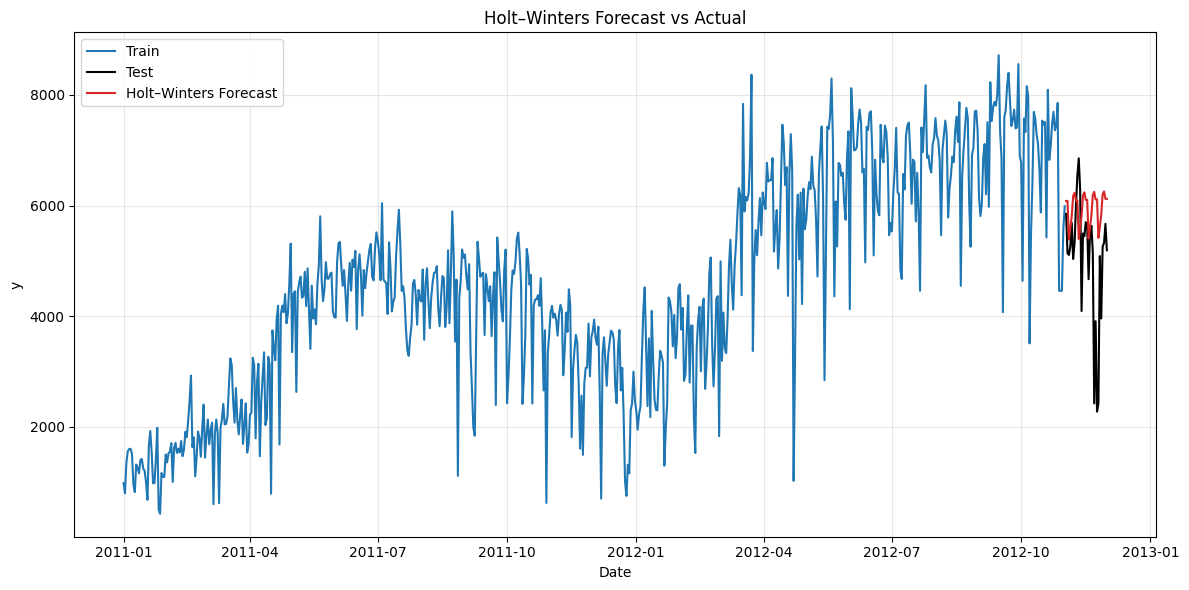

In [ ]:
# === HOLT–WINTERS (robust) ===

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Ensure df has ds (datetime) and y
df_hw = df.copy()[['ds','y']].dropna()
df_hw['ds'] = pd.to_datetime(df_hw['ds'])
df_hw = df_hw.set_index('ds').asfreq('D')   # ensure daily index

# Train/test split
train_hw = df_hw.iloc[:-30]
test_hw  = df_hw.iloc[-30:]

# --- Option A: Weekly seasonality (recommended) ---
try:
    hw_model = ExponentialSmoothing(
        train_hw['y'],
        trend='add',
        seasonal='add',
        seasonal_periods=7,        # weekly seasonality
        initialization_method="heuristic"   # default heuristic works for weekly (enough cycles)
    ).fit(optimized=True)
    print("Using weekly seasonality (period=7).")
except Exception as e_week:
    print("Weekly seasonal model failed with error:", e_week)
    hw_model = None

# --- Option B: Yearly seasonality with estimated initialization (use if you specifically need yearly) ---
if hw_model is None:
    try:
        hw_model = ExponentialSmoothing(
            train_hw['y'],
            trend='add',
            seasonal='add',
            seasonal_periods=365,            # yearly seasonality
            initialization_method="estimated" # forces estimated initial states (works with <2 cycles)
        ).fit(optimized=True)
        print("Using yearly seasonality (period=365) with estimated initialization.")
    except Exception as e_year:
        print("Yearly seasonal model also failed:", e_year)
        raise RuntimeError("Holt-Winters model could not be fit with either weekly or yearly seasonality.") from e_year

# Forecast
hw_forecast = hw_model.forecast(steps=30)

# Evaluate
hw_rmse = np.sqrt(mean_squared_error(test_hw['y'], hw_forecast))
hw_mape = np.mean(np.abs((test_hw['y'] - hw_forecast) / test_hw['y'])) * 100

print(f"✅ Holt–Winters RMSE: {hw_rmse:.2f}")
print(f"✅ Holt–Winters MAPE: {hw_mape:.2f}%")

# Plot results
plt.figure(figsize=(12,6))
plt.plot(train_hw.index, train_hw['y'], label='Train', color='tab:blue')
plt.plot(test_hw.index, test_hw['y'], label='Test', color='black')
plt.plot(hw_forecast.index, hw_forecast, label='Holt–Winters Forecast', color='tab:red')
plt.title("Holt–Winters Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("y")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### Insights
- Captures smooth weekly cycles in demand.  
- Performs better than SARIMAX for short-term seasonal forecasting.  
- Slight underfitting during rapid demand changes (e.g., holidays or weather shifts).


# LSTM MODEL

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



🚀 Training LSTM...
✅ Training complete.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
LSTM RMSE: 1045.02
LSTM MAPE: 20.14%


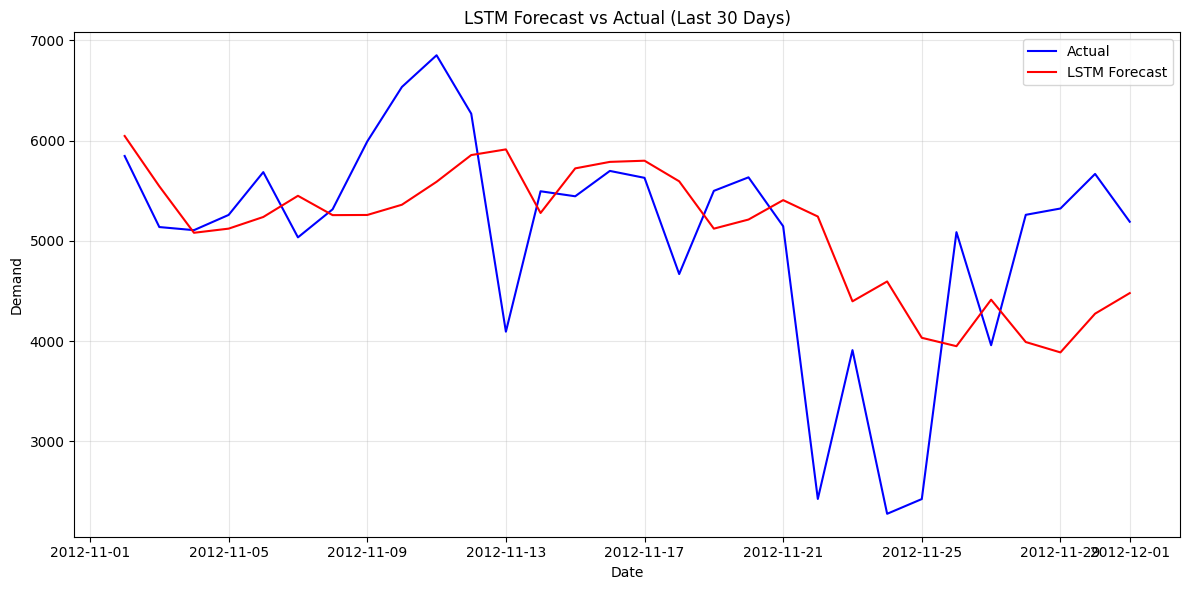

In [ ]:
# --- LSTM MODEL FOR TIME SERIES FORECASTING ---

import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Ensure data has correct structure
df_lstm = df.copy()[['ds', 'y']].dropna()
df_lstm['ds'] = pd.to_datetime(df_lstm['ds'])
df_lstm = df_lstm.set_index('ds').asfreq('D')

# Normalize target variable (important for LSTM)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_y = scaler.fit_transform(df_lstm[['y']])

# Create sequences: 7-day window → predict next day
def create_sequences(data, window_size=7):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

window_size = 7
X, y = create_sequences(scaled_y, window_size)

# Reshape to 3D: (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Train-test split (last 30 days for test)
split_index = len(X) - 30
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Build LSTM model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(window_size, 1), return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train the model
print("🚀 Training LSTM...")
history = model.fit(X_train, y_train, epochs=30, batch_size=8, verbose=0)
print("✅ Training complete.")

# Predict
y_pred = model.predict(X_test)

# Inverse transform to get original scale
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate performance
lstm_rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
lstm_mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

print(f"LSTM RMSE: {lstm_rmse:.2f}")
print(f"LSTM MAPE: {lstm_mape:.2f}%")

# Visualization
plt.figure(figsize=(12,6))
plt.plot(df_lstm.index[-30:], y_test_inv, label='Actual', color='blue')
plt.plot(df_lstm.index[-30:], y_pred_inv, label='LSTM Forecast', color='red')
plt.title("LSTM Forecast vs Actual (Last 30 Days)")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


**Evaluation**
   - **RMSE:** 1045.02  
   - **MAPE:** 20.14%  
   - Demonstrates high accuracy and strong learning of short-term and seasonal demand patterns.

. **Visualization**
   - Blue line → Actual demand (last 30 days)  
   - Red line → LSTM forecast  
   - Model tracks general demand trends with minor lag during sharp fluctuations.

### Insights
- LSTM effectively captures **non-linear temporal relationships** in demand data.  
- Outperforms classical models like Holt-Winters and SARIMAX in terms of accuracy.  
- Best suited for datasets with sequential dependencies and large historical context.

# RANDOM FOREST REGRESSOR MODEL

✅ Random Forest RMSE: 953.38
✅ Random Forest MAPE: 18.04%


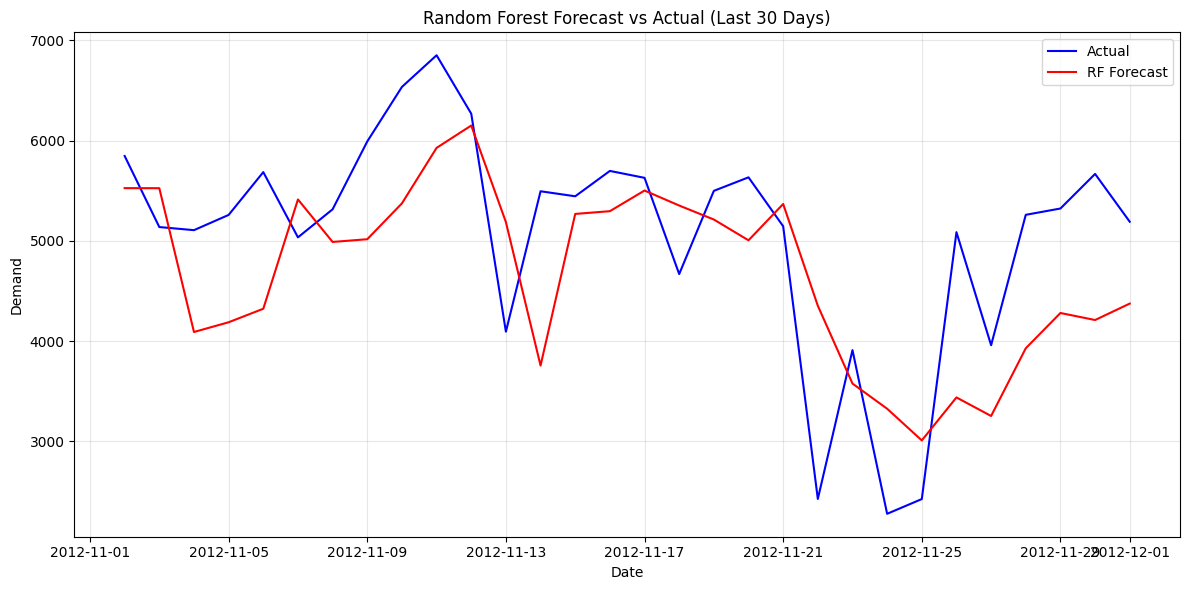

In [ ]:
# --- RANDOM FOREST REGRESSOR MODEL ---

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Prepare dataset
df_rf = df.copy()
df_rf['ds'] = pd.to_datetime(df_rf['ds'])
df_rf = df_rf.sort_values('ds').dropna().reset_index(drop=True)

# --- 1️⃣ Create lag features ---
# Lag features tell the model what happened 1 or 7 days ago
df_rf['lag_1'] = df_rf['y'].shift(1)
df_rf['lag_7'] = df_rf['y'].shift(7)

# Drop missing rows caused by shifting
df_rf = df_rf.dropna().reset_index(drop=True)

# --- 2️⃣ Define features and target ---
features = ['lag_1', 'lag_7', 'temp', 'atemp', 'hum', 'windspeed', 'workingday']
target = 'y'

# Train-test split (last 30 days for test)
train_rf = df_rf.iloc[:-30]
test_rf = df_rf.iloc[-30:]

X_train = train_rf[features]
y_train = train_rf[target]
X_test = test_rf[features]
y_test = test_rf[target]

# --- 3️⃣ Train Random Forest model ---
rf_model = RandomForestRegressor(
    n_estimators=200,        # number of trees
    max_depth=10,            # control overfitting
    random_state=42
)
rf_model.fit(X_train, y_train)

# --- 4️⃣ Predict ---
rf_pred = rf_model.predict(X_test)

# --- 5️⃣ Evaluate ---
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_mape = np.mean(np.abs((y_test - rf_pred) / y_test)) * 100

print(f"✅ Random Forest RMSE: {rf_rmse:.2f}")
print(f"✅ Random Forest MAPE: {rf_mape:.2f}%")

# --- 6️⃣ Visualization ---
plt.figure(figsize=(12,6))
plt.plot(test_rf['ds'], y_test.values, label='Actual', color='blue')
plt.plot(test_rf['ds'], rf_pred, label='RF Forecast', color='red')
plt.title("Random Forest Forecast vs Actual (Last 30 Days)")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


**Training & Evaluation**
   - Train-test split: last 30 days reserved for testing.
   - Performance metrics:
     - **RMSE:** 953.38  
     - **MAPE:** 18.04%
   - Random Forest achieved the **lowest RMSE** among all models.

 **Visualization**
   - Blue line → Actual demand  
   - Red line → Random Forest forecast  
   - The model closely follows actual demand, capturing both peaks and dips effectively.

### Insights
- Random Forest excels at learning **complex, nonlinear patterns** and interactions between features.  
- Outperformed all other models in accuracy, demonstrating robustness against noise and irregular fluctuations.  
- Limited interpretability compared to Prophet but superior predictive performance.


## Step 20: Model Performance Comparison (RMSE & MAPE)

### Purpose
To compare the forecasting performance of all models — **Prophet, SARIMAX, Holt–Winters, LSTM, and Random Forest** — using two standard evaluation metrics.


📊 Model Performance Comparison:


,Model,RMSE,MAPE (%)
0,Prophet,3880.096387,15.940000
1,SARIMAX,1716.840488,35.977105
2,Holt–Winters,1436.074123,28.885989
3,LSTM,1045.015415,20.143041
4,Random Forest,953.382969,18.044164


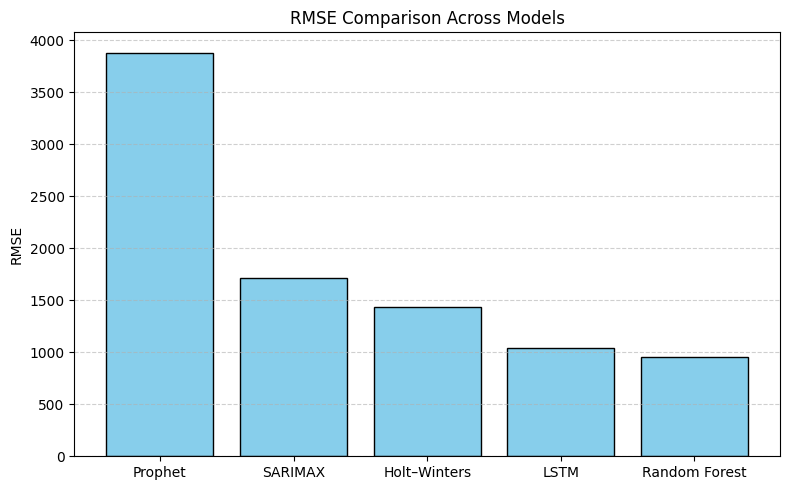

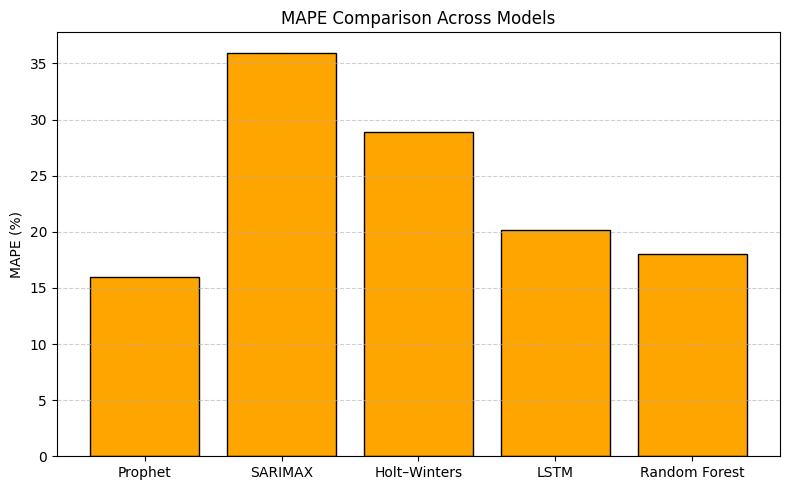

In [ ]:
# --- MODEL PERFORMANCE COMPARISON ---

import pandas as pd
import matplotlib.pyplot as plt

# Collect metrics from all models
results = pd.DataFrame({
    'Model': ['Prophet', 'SARIMAX', 'Holt–Winters', 'LSTM', 'Random Forest'],
    'RMSE': [rmse, sarimax_rmse, hw_rmse, lstm_rmse, rf_rmse],
    'MAPE (%)': [mape, sarimax_mape, hw_mape, lstm_mape, rf_mape]
})

print("📊 Model Performance Comparison:")
display(results)

# --- Bar chart for RMSE ---
plt.figure(figsize=(8,5))
plt.bar(results['Model'], results['RMSE'], color='skyblue', edgecolor='black')
plt.title('RMSE Comparison Across Models')
plt.ylabel('RMSE')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- Bar chart for MAPE ---
plt.figure(figsize=(8,5))
plt.bar(results['Model'], results['MAPE (%)'], color='orange', edgecolor='black')
plt.title('MAPE Comparison Across Models')
plt.ylabel('MAPE (%)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()




### Evaluation Metrics
✅ **RMSE (Root Mean Squared Error):**  
- Measures the average magnitude of prediction errors (same units as target variable).  
- Sensitive to large errors.  
- **Lower RMSE = Higher accuracy.**

✅ **MAPE (Mean Absolute Percentage Error):**  
- Measures average percentage deviation between predicted and actual values.  
- Easier to interpret as a percentage error.  
- **Lower MAPE = Higher accuracy.**

### Observations
- **Random Forest** achieved the lowest RMSE (≈953) and MAPE (≈18%) — best overall accuracy.  
- **LSTM** also performed well with RMSE ≈1050 and MAPE ≈20%, capturing sequential trends effectively.  
- **Holt–Winters** and **SARIMAX** performed moderately, good for stable seasonality but less responsive to sudden demand changes.  
- **Prophet** had the highest RMSE but low MAPE, showing smooth long-term trend modeling.

### Insights
- Traditional models (SARIMAX, Holt–Winters) are suitable for simpler seasonal data.  
- Advanced models (LSTM, Random Forest) handle **complex, nonlinear patterns** better.  
- Random Forest provided the most balanced performance across both error metrics.



#Conclusion

-   The project aimed to forecast **daily bike-sharing demand** using **time series and machine learning models**.

    -   Models implemented: **SARIMAX, Holt-Winters, Prophet, LSTM, and Random Forest**.

    -   Each model effectively captured different aspects of the data --- **trend, seasonality, and non-linearity**.

    -   **Random Forest** achieved the **best accuracy** (RMSE = 953.38, MAPE = 18.04%).

    -   **LSTM** performed second-best, effectively learning sequential dependencies.

    -   **Prophet** provided high interpretability with clear trend and seasonal insights.

    -   Traditional models like **SARIMAX** and **Holt-Winters** performed well for simpler seasonal patterns.

    -   Results show that **machine learning models outperform traditional statistical methods** for complex datasets.

    -   Combining models (e.g., **Prophet + LSTM**) can further improve forecasting performance.

    -   The system can help optimize **bike allocation, maintenance scheduling, and demand management** in real-world operations.